In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from lifelines.utils import concordance_index
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('../Dataset/Churn_Modelling.csv')
pd.set_option("display.max_columns", False)
pd.set_option("display.max_rows", 100)

## 1 Exploratory Data Analysis

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# 10,000 rows and 13 variables (exlcuding row number)

data.shape

(10000, 14)

In [5]:
# Descriptive statistics

data.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


In [6]:
data.groupby("Exited").agg("mean")[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "EstimatedSalary"]]

# Examine the mean for churned and non-churned customers
    # Churned customers are significantly older (+20%)
    # Tenure seems to not affect churn
    # Balance is significantly higher for churned customers (+25%)
    # Number of products used is -4% less for churned customers
    # Active members are (unsurprisingly) less likely to churn
    # Usage of credit cards or the estimated salary doesn´t seem to affect churn significantly

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,EstimatedSalary
Exited,,,,,,,
0,651.853196,37.408389,5.033279,72745.296779,1.544267,0.707146,99738.391772
1,645.351497,44.837997,4.932744,91108.539337,1.475209,0.699067,101465.677531


In [7]:
data.groupby("Exited").agg(["mean", "median"])[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"]]

# Checking skewness of variables
    # Larger differences between mean and median for balance and NomofProducts

CreditScore               Age  ... IsActiveMember EstimatedSalary           
              mean median       mean  ...         median            mean     median
Exited                                ...                                          
0       651.853196    653  37.408389  ...              1    99738.391772   99645.04
1       645.351497    646  44.837997  ...              0   101465.677531  102460.84

[2 rows x 16 columns]

In [8]:
data.groupby("Gender").agg({"Exited":"mean"})

# Women are more likely to churn

,Exited
Gender,
Female,0.250715
Male,0.164559


In [9]:
data.groupby("Geography").agg({"Exited":"mean"})

# Germans are significantly more likely to churn

,Exited
Geography,
France,0.161548
Germany,0.324432
Spain,0.166734


## 2 Data Cleaning & Wrangeling

Removing irrelavant data

In [10]:
# Removing RowNumber, CustomerId, Surname due to irrelavance to analysis and machine learning
data.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

Missing Values

In [11]:
data.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [12]:
data.replace("", np.nan).isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [13]:
data.replace(" ", np.nan).isna().sum()

# No missing values. Fantastic.

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Checking datatypes

In [14]:
data.info()
# Alle datatypes seems appropriate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Checking Unique Values 

In [15]:
data.nunique()

CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2
dtype: int64

In [16]:
data[["Geography"]].apply(pd.value_counts)
# Needs to be one hot encoded for ml model

,Geography
France,5014
Germany,2509
Spain,2477


In [17]:
data[["Gender"]].apply(pd.value_counts)
# Needs to be one hot encoded for ml model

,Gender
Male,5457
Female,4543


In [18]:
data[["NumOfProducts"]].apply(pd.value_counts)

,NumOfProducts
1,5084
2,4590
3,266
4,60


In [19]:
data[["HasCrCard"]].apply(pd.value_counts)

,HasCrCard
1,7055
0,2945


In [20]:
data[["IsActiveMember"]].apply(pd.value_counts)

,IsActiveMember
1,5151
0,4849


In [21]:
data[["Exited"]].apply(pd.value_counts)

,Exited
0,7963
1,2037


In [22]:
# Dataset was already well cleaned. 

## 3 Data Preprocessing

One Hot Encoding

In [23]:
data = pd.get_dummies(data, columns=["Geography", "Gender"], drop_first=True)

In [24]:
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Scaling

In [25]:
# Dependent variable
y = data["Exited"]

# Independet variable withoug boolean variables
X = data.drop(["Exited", "HasCrCard", "IsActiveMember", "Geography_Germany", "Geography_Spain", "Gender_Male"], axis=1)
cols = X.columns
index = X.index

bol_data = data[["HasCrCard", "IsActiveMember", "Geography_Germany", "Geography_Spain", "Gender_Male"]]

In [26]:
std = StandardScaler()
scaled_fit = std.fit(X)

In [27]:
X = pd.DataFrame(scaled_fit.transform(X), columns = cols, index = index)

In [28]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.021886
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0.216534
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.240687
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-0.108918
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,-0.365276


In [29]:
pd.DataFrame(scaled_fit.transform(X), columns = cols, index = index)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,-6.734251,-3.683345,-2.093533,-1.225867,-4.198207,-1.740469
1,-6.735429,-3.692438,-2.213095,-1.225846,-4.198207,-1.740465
2,-6.746776,-3.683345,-1.376159,-1.225826,1.713916,-1.740465
3,-6.725686,-3.710622,-2.213095,-1.225867,-1.242146,-1.740471
4,-6.709521,-3.674253,-2.093533,-1.225835,-4.198207,-1.740476
...,...,...,...,...,...,...
9995,-6.717978,-3.710622,-1.734846,-1.225867,-1.242146,-1.740470
9996,-6.745278,-3.746992,-1.137034,-1.225853,-4.198207,-1.740469
9997,-6.724616,-3.737899,-1.495721,-1.225867,-4.198207,-1.740487
9998,-6.717871,-3.683345,-1.973971,-1.225848,-1.242146,-1.740471


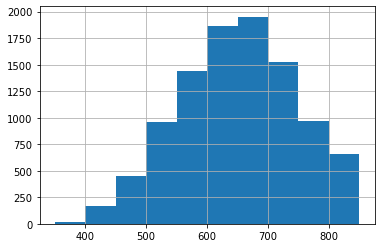

In [30]:
data["CreditScore"].hist()

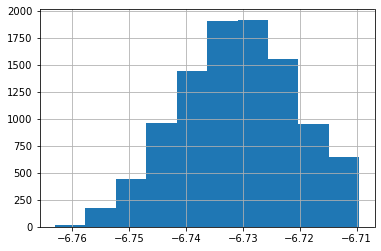

In [31]:
pd.DataFrame(scaled_fit.transform(X), columns = cols, index = index)["CreditScore"].hist()

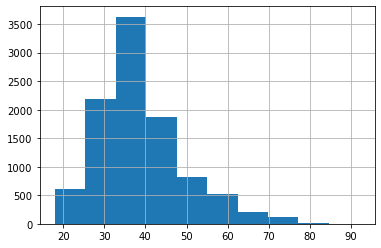

In [32]:
data["Age"].hist()

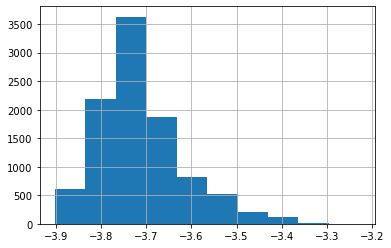

In [33]:
pd.DataFrame(scaled_fit.transform(X), columns = cols, index = index)["Age"].hist()

# Scaled features look fine

In [34]:
# Combining boolean data with scaled data
X = pd.concat([X, bol_data], axis = 1)
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,HasCrCard,IsActiveMember,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.021886,1,1,0,0,0
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0.216534,0,1,0,1,0
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.240687,1,0,0,0,0
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-0.108918,0,0,0,0,0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,-0.365276,1,1,0,1,0


Train-Test Seperation

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [36]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 11) (2000, 11) (8000,) (2000,)


## 4 Machine Learning Models

Train models

In [37]:
# Train models
lr = LogisticRegression()
lr.fit(X_train, y_train)

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

rcs = RandomForestClassifier()
rcs.fit(X_train, y_train)

RandomForestClassifier()

Accuracy Scores

In [38]:
lr_acc = accuracy_score(y_test, lr.predict(X_test))
dtc_acc = accuracy_score(y_test, dtc.predict(X_test))
rcs_acc = accuracy_score(y_test, rcs.predict(X_test))

print(f"Logistic Regression achieved an accuracy of {lr_acc}")
print(f"Decision Tree Classifier achieved an accuracy of {dtc_acc}")
print(f"Random Forest Classifier achieved an accuracy of {rcs_acc}")


Logistic Regression achieved an accuracy of 0.806
Decision Tree Classifier achieved an accuracy of 0.789
Random Forest Classifier achieved an accuracy of 0.863


In [39]:
lr_f1=f1_score(y_train, X_, average='weighted')


NameError: name 'X_' is not defined

### Variable importance levels

Linear Regression / Correlation Coefficient

In [40]:
lr_weights = pd.Series(lr.coef_[0], index=X.columns.values)
lr_weights.sort_values(ascending=False)

Geography_Germany    0.796940
Age                  0.748113
Balance              0.128710
EstimatedSalary      0.011605
Tenure              -0.024162
Geography_Spain     -0.048677
HasCrCard           -0.057607
CreditScore         -0.070857
NumOfProducts       -0.090808
Gender_Male         -0.532831
IsActiveMember      -1.008998
dtype: float64

Text(0, 0.5, 'Feature')

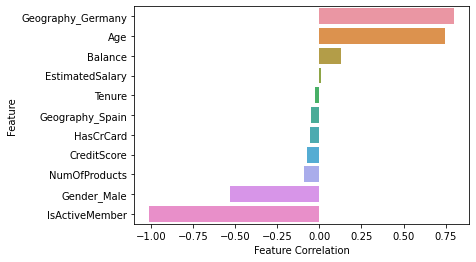

In [41]:
sns.barplot(lr_weights.sort_values(ascending=False), lr_weights.sort_values(ascending=False).index)
plt.xlabel('Feature Correlation')
plt.ylabel('Feature')

Decision Tree Classifier / Feature Importance

In [42]:
dtc_fi = dtc.feature_importances_
dtc_rfi = np.abs(dtc_fi)/np.sum(np.abs(dtc_fi))
lab = X_train.columns
df_dtc_rfi = pd.DataFrame(data={'Feature Importance': dtc_rfi}, index=lab)
df_dtc_rfi = df_dtc_rfi.sort_values(by='Feature Importance', ascending=True)
df_dtc_rfi

,Feature Importance
HasCrCard,0.013923
Geography_Spain,0.014046
Geography_Germany,0.020414
Gender_Male,0.023115
IsActiveMember,0.055166
Tenure,0.058221
NumOfProducts,0.118077
CreditScore,0.145682
Balance,0.147414
EstimatedSalary,0.176499


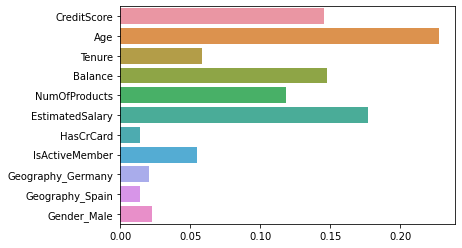

In [43]:
sns.barplot(dtc_rfi, X_train.columns)

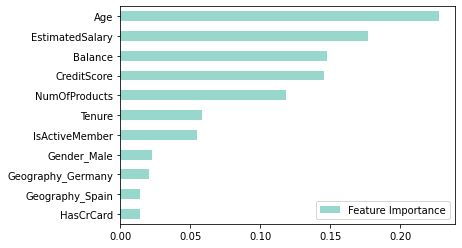

In [44]:
df_dtc_rfi.plot.barh(y='Feature Importance', cmap="Set3", alpha=0.9, linewidth=0)

Decision Tree Classifier / Feature Importance

In [45]:
rcs_fi = dtc.feature_importances_
rcs_rfi = np.abs(rcs_fi)/np.sum(np.abs(rcs_fi))
lab = X_train.columns
df_rcs_rfi = pd.DataFrame(data={'Feature Importance': rcs_rfi}, index=lab)
df_rcs_rfi = df_rcs_rfi.sort_values(by='Feature Importance', ascending=True)
df_rcs_rfi

,Feature Importance
HasCrCard,0.013923
Geography_Spain,0.014046
Geography_Germany,0.020414
Gender_Male,0.023115
IsActiveMember,0.055166
Tenure,0.058221
NumOfProducts,0.118077
CreditScore,0.145682
Balance,0.147414
EstimatedSalary,0.176499


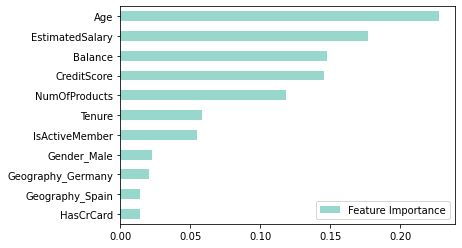

In [46]:
df_rcs_rfi.plot.barh(y='Feature Importance', cmap="Set3", alpha=0.9, linewidth=0)

In [ ]:
# f1 